# Example: Polynomial Cureve Fitting

Observse a real-valued input variable $x$ $\rightarrow$ predict a real-valued target variable $t$ 

* $\textbf{x} \equiv (x_1, \cdots, x_i, \cdots, x_N)^T, \quad x_i \in [0, 1]$
* $\textbf{t} \equiv (t_1, \cdots, t_i, \cdots, t_N)^T, \quad t_i = \sin(2\pi x_i)$

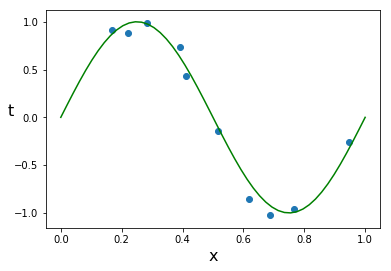

In [109]:
import numpy as np
import matplotlib.pylab as plt
# making data
np.random.seed(23)
N = 10
x = np.random.rand(N)
t = np.sin(2*np.pi*x) + np.random.randn(N) * 0.1
x_sin = np.linspace(0, 1)
t_sin = np.sin(2*np.pi*x_sin)
plt.plot(x_sin, t_sin, c='green')
plt.scatter(x, t)
plt.xlabel('x', fontsize=16)
plt.ylabel('t', rotation=0, fontsize=16)
plt.show()

* Goal: exploit this training set in order to make predictions of the value $\hat{t}$ of the target variable for some new value $\hat{x}$ of the input variable.
* Use some theories:
    * Probability theory: provides a framework for expressing such uncertainty in a precise and quantitative manner
    * Decision theory: allows us to exploit this probabilistic representation in order to make predictions that are optimal according to appropriate criteria
* For the moment, let's use polynomial function, where $M$ is the order of polynomial. $y(x, \mathbf{w})$ is a linear function of coefficients ($\mathbf{w}$)

$$y(x, \mathbf{w}) = w_0 + w_1 x + w_2 x^2 + \cdots + w_M x^M = \sum_{j=0}^{M} w_j x^j$$

In [163]:
from numpy.polynomial import polynomial as P

In [165]:
def polynomial_function(x, w, m):
    assert w.size == m+1, "coefficients number must same as M"
    x_poly = np.array([x**i for i in range(m+1)])  # shape (M, x.size)
    return np.dot(w, x_poly)

In [166]:
M = 3
w = np.random.randn(M+1)
t_hat = polynomial_function(x, w, M)
t_hat

array([-0.19563868, -1.21267678, -0.6263281 , -0.07227229, -0.07108994,
       -0.44735119, -0.07747279, -0.10315195, -0.32598196, -0.11317532])

In [167]:
P.polyval(x, w)

array([-0.19563868, -1.21267678, -0.6263281 , -0.07227229, -0.07108994,
       -0.44735119, -0.07747279, -0.10315195, -0.32598196, -0.11317532])

* The values of the coefficients will be determined by fitting the polynomial to the training data, this can be done by minimizing an error function, which measure the misfit between the function $y(x, \mathbf{w})$ and training data points.

$$E(\mathbf{w}) = \dfrac{1}{2} \sum_{n=1}^{N} (y(x_n, \mathbf{w}) - t_n)^2$$

In [112]:
def error_function(pred, t):    
    return (1/2)*((pred-t)**2).sum()

In [113]:
error_value = error_function(t_hat, t)
error_value

9.98412457060073

* Because error function is quadratic function of $\mathbf{w}$, its derivatives with respect to the coefficients will be linear in the elements of $\mathbf{w}$, so the minimization of the error function has a unique solution.
* The remain problem is choosing the order $M$, this is called **model comparison or model selection**.
* Then how to choose optimal $M$?
    * use test data with 100 data points
    * evaluate the residual value of error

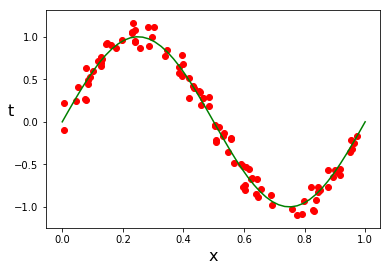

In [114]:
N_test = 100 
x_test = np.random.rand(N_test)
t_test = np.sin(2*np.pi*x_test) + np.random.randn(N_test) * 0.1
plt.plot(x_sin, t_sin, c='green')
plt.scatter(x_test, t_test, c='red')
plt.xlabel('x', fontsize=16)
plt.ylabel('t', rotation=0, fontsize=16)
plt.show()

In [115]:
def root_mean_square_error(error, n_samples):
    return np.sqrt(2*error/n_samples)

In [116]:
# M=3
error = error_function(polynomial_function(x_test, w, M), t_test)
rms = root_mean_square_error(error, N_test)
rms

1.401099929706059

In [168]:
def polynomial_function_prime(x, m):
    """dy/dw"""
    return np.array([x**i for i in range(m+1)]).sum(1)  # shape (M)

In [169]:
P.polyder(w)

array([ 0.36731487, -0.42360875, -4.39650521])

In [170]:
polynomial_function_prime(x, M)

array([10.        ,  5.00894765,  3.08339484,  2.16367063])

In [157]:
np.polynomial.polynomial.polyfit(x, t, M)

array([ -0.72150447,  15.99621371, -43.66892598,  28.85751961])

In [160]:
polynomial_function_prime(x, M)

array([10.        ,  5.00894765,  3.08339484,  2.16367063])

In [161]:
w_raw = np.random.randn(M+1)
optimal_w, train_error = train_phase(x, t, w_raw, M, step=200, lr=0.00001)

In [162]:
optimal_w

array([-0.04427254,  0.74535809, -0.86678067, -0.26295935])

Let's find optimal $M$. Think careful about derivatives

$$\begin{aligned}
\dfrac{\partial E}{\partial \mathbf{w}} &= \dfrac{\partial E}{\partial y} \dfrac{\partial y}{\partial \mathbf{w}} \\
&= 1 \cdot \sum_{j=0}^{M} x^j
\end{aligned}$$

In [159]:
def polynomial_function_prime(x, m):
    """dy/dw"""
    return np.array([x**i for i in range(m+1)]).sum(1)  # shape (M)

In [144]:
np.array([x**i for i in range(M+1)])[:, 0]

array([1.        , 0.51729788, 0.2675971 , 0.13842741])

In [90]:
def train_phase(x, t, w, m, step=10, lr=0.1):
    """use gradient descent update"""
    errors = []
    for _ in range(step):
        t_hat = polynomial_function(x, w, m)
        error_value = error_function(t_hat, t)
        w -= lr*(1*polynomial_function_prime(x, m))
        errors.append(error_value)
    return w, np.sum(errors)

In [91]:
def get_rms_error(t_hat, t, n_sample, m):
    error = error_function(t_hat, t)
    rms = root_mean_square_error(error, n_sample)
    return rms

Train Error for M=0 is 12668.8686 | rms_train: 1.0496 rms_test: 0.8820


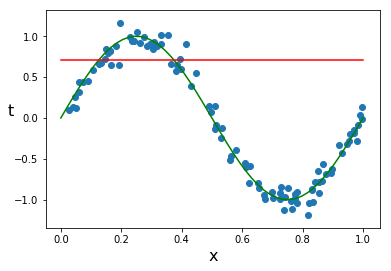

Train Error for M=1 is 3160.3776 | rms_train: 0.6179 rms_test: 0.5912


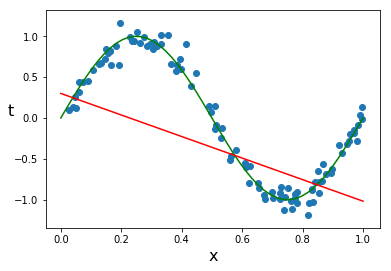

Train Error for M=2 is 26322.2631 | rms_train: 1.4992 rms_test: 1.2532


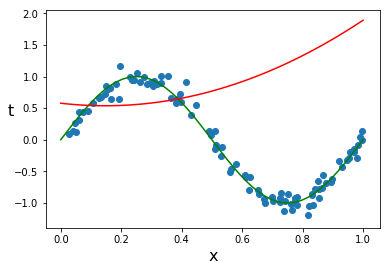

Train Error for M=3 is 15685.6805 | rms_train: 1.3872 rms_test: 1.2819


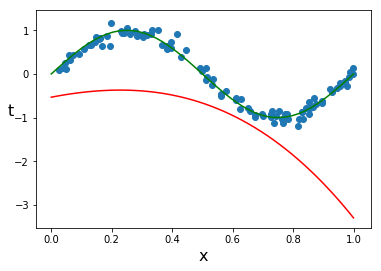

Train Error for M=4 is 27452.4662 | rms_train: 1.6434 rms_test: 1.7222


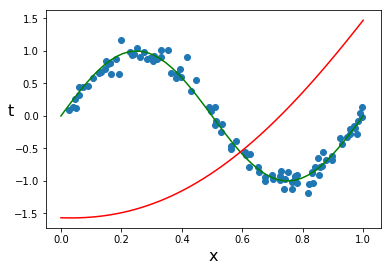

Train Error for M=5 is 52224.1426 | rms_train: 2.4480 rms_test: 2.3103


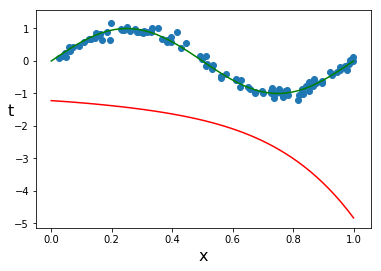

Train Error for M=6 is 10039.0619 | rms_train: 0.8993 rms_test: 0.7630


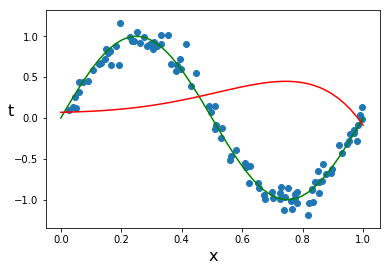

Train Error for M=7 is 10763.2413 | rms_train: 1.1899 rms_test: 1.1671


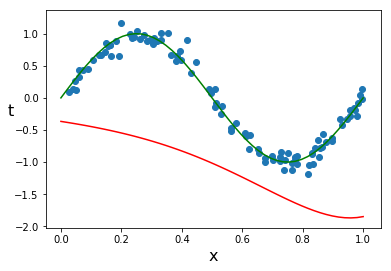

Train Error for M=8 is 3494.9413 | rms_train: 0.6744 rms_test: 0.6676


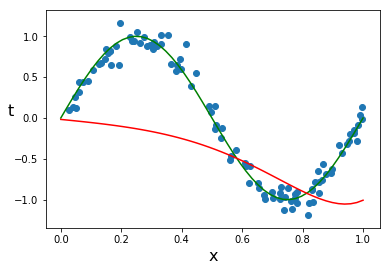

Train Error for M=9 is 16272.0816 | rms_train: 1.4139 rms_test: 1.3135


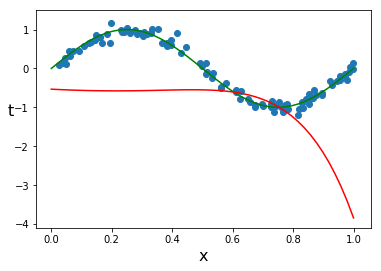

In [104]:
all_w = []
all_rms_train = []
all_rms_test = []
for m in range(10):
    w_raw = np.random.randn(m+1)
    optimal_w, train_error = train_phase(x, t, w_raw, m, step=200, lr=0.00001)
    
    t_hat = polynomial_function(x, optimal_w, m)
    t_hat_test = polynomial_function(x_test, optimal_w, m)
    
    rms_train = get_rms_error(t_hat, t, N, m)  # N=10
    rms_test = get_rms_error(t_hat_test, t_test, N_test, m)  # N_test = 100
    print(f"Train Error for M={m} is {train_error:.4f} | rms_train: {rms_train:.4f} rms_test: {rms_test:.4f}")
    
    plt.plot(x_sin, t_sin, c="green")
    plt.plot(x_sin, polynomial_function(x_sin, optimal_w, m), c="red")
    plt.scatter(x, t)
    plt.xlabel('x', fontsize=16)
    plt.ylabel('t', rotation=0, fontsize=16)
    plt.show()
    
    all_w.append(optimal_w)
    all_rms_train.append(rms_train)
    all_rms_test.append(rms_test)

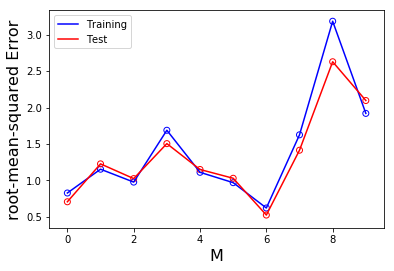

In [101]:
plt.scatter(np.arange(10), all_rms_train, facecolors='none', edgecolors='b')
plt.plot(np.arange(10), all_rms_train, c='b', label='Training')
plt.scatter(np.arange(len(all_rms_test)), all_rms_test, facecolors='none', edgecolors='r')
plt.plot(np.arange(len(all_rms_test)), all_rms_test, c='r', label='Test')
plt.legend()
plt.ylabel("root-mean-squared Error", fontsize=16)
plt.xlabel("M", fontsize=16)
plt.show()